In [2]:
% load_ext rpy2.ipython

In [19]:
%%R
library("phyloseq")
library(ggplot2)
library(dplyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [22]:
%%R
physeq = import_biom("../../SeqData/otu_table.tax.meta.biom", "../../SeqData/trees/fulltree.tre", parseFunction = parse_taxonomy_greengenes)

In [12]:
%%R
physeq.buff <- subset_samples(physeq,Month==2.5|Month==3)
physeq.buff <- subset_samples(physeq.buff,Trtmt=="K"|Trtmt=="Q"|Trtmt=="F")
#Making physeq with only the PCR replicated data
physeq.buff

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4857 taxa and 77 samples ]
sample_data() Sample Data:       [ 77 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 4857 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4857 tips and 4855 internal nodes ]


In [13]:
%%R
ps <- physeq.buff

In [14]:
%%R
# Normalizes the sample counts by the total - i.e., reporting what fraction of each sample each OTU makes up.
ps_snorm = transform_sample_counts(ps, function(x) x / sum(x))

In [29]:
%%R
# Computing the Bray distance matrix and NMDS in parallel

ord.NMDS.full = ordinate(ps_snorm, method = "NMDS", distance = "unifrac", weighted=TRUE)
NMDS.full = plot_ordination(ps_snorm, ord.NMDS.full, axes = c(1,2), justDF = TRUE)
NMDS.full$Samples = rownames(NMDS.full)

Run 0 stress 0.151002 
Run 1 stress 0.1579359 
Run 2 stress 0.1525953 
Run 3 stress 0.1525986 
Run 4 stress 0.1579369 
Run 5 stress 0.1509815 
... New best solution
... procrustes: rmse 0.004593737  max resid 0.03703097 
Run 6 stress 0.157936 
Run 7 stress 0.1512818 
... procrustes: rmse 0.008073376  max resid 0.03896373 
Run 8 stress 0.1510022 
... procrustes: rmse 0.004601864  max resid 0.03706423 
Run 9 stress 0.151282 
... procrustes: rmse 0.008085044  max resid 0.03896545 
Run 10 stress 0.1512617 
... procrustes: rmse 0.006735719  max resid 0.03924461 
Run 11 stress 0.15098 
... New best solution
... procrustes: rmse 0.0006603774  max resid 0.004726052 
*** Solution reached


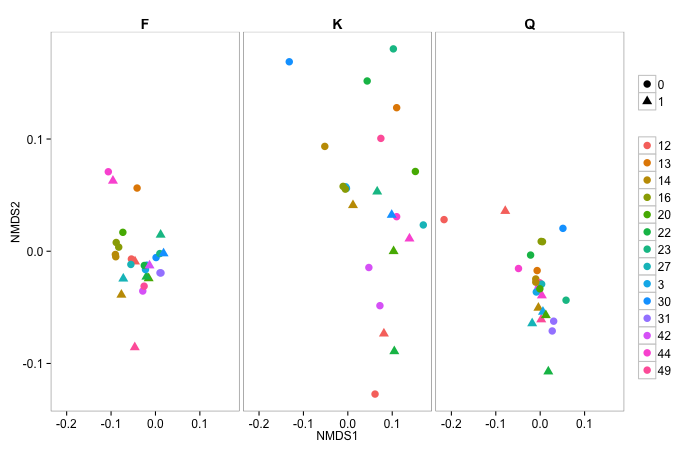

In [30]:
%%R -h 450 -w 700
D <- NMDS.full
# Sets the relevant ordination

#D$Trtmt <- as.factor(D$Trtmt)
#levels(D$Trtmt) <- c("Ferrihydrite", "Heavy Fraction", "Kaolinite", "Quartz", "Soil")

colnames(D)[1:2]<-c("NMDS1","NMDS2")
# Renames the axis columns

#D$AmdmtName = ifelse(D$Amdmt==1,"PyOM",ifelse(D$Amdmt==2,"Stover","Soil only"))
#D$AmdmtName = factor(D$AmdmtName, levels=c("Soil only", "PyOM", "Stover"))
#D$DayName = ifelse(D$Day==1,"Day 12",ifelse(D$Day==2,"Day 82","Day 1"))

# Creates an plot object, using the df.sites data, with the x and y axes specified as the PCoA axes,
p = ggplot(D, aes(x = NMDS1, y = NMDS2, color = Cosm, shape = Buff))

# Determines the size of the symbols
p = p  + geom_point(size=3.5)

p = p + guides(colour = guide_legend(""), shape = guide_legend(""))

# Determines the color theme of the plot overall
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14, face="bold"),axis.text = element_text(size=12),legend.text = element_text(size=12),
          strip.background = element_rect(colour="white", fill="white"))

# Displays the plot object
p = p + facet_wrap(~Trtmt)
# The axis scales could be all optimized individually
# p = p + facet_grid(~Month)
# Adds a "facet_wrap" to it, which means it will plot it separately by whatever we specify - here, Days
#plot.full.byDay = p
p

Samples with different freezing treatments before the buffer are similar.  
There is more of a sample effect than a freezing effect - it's not consistently shifted in one direction or another. Surprisingly, F reps are especially tight  
However, it seems like there's a bit of a buffer effect - I will just exclude the samples that were direct-extracted, and use only Buff=0 treatments  
But, the problem is that the heavy fraction samples ("H") only were extracted in the first round (Buff=1). So, any analyses where we want to compare those, we should use the same buffer treatment. A bit messy, but could do ad-hoc.  
Could also just facet everything by buffer...
But there's not very complete buffer data. The only reason to use it is to get the heavy fraction. Maybe we can just include the heavy fraction, which makes it not perfectly comparable, but can show that for other samples, expected to be even more affected by freezing, buffer before vs. after freezing made no difference. I think I'll go with that.  
Actually, I could also just use collapsereplicates command in DESeq, at least for those and related analyses.  
Looking into it, it does seem like adding the replicate counts together work - they are all observations of the same environmental sample. Normalizing and adding wouldn't make sense, becuse it could skew and under-sampled sample.  
Alternatively, phyloseq has the command merge_samples, which does the same thing

In [20]:
%%R
sample.data<-data.frame(sample_data(physeq)) %>%
    dplyr::group_by(Trtmt,Month,Buff) %>%
    dplyr::summarize(total=n())
sample.data

Source: local data frame [19 x 4]
Groups: Trtmt, Month

   Trtmt Month Buff total
1      B                1
2      F     2    0     4
3      F   2.5    0    13
4      F   2.5    1     5
5      F     3    0     5
6      F     3    1     5
7      H   2.5    1     3
8      K   2.5    0    11
9      K   2.5    1     2
10     K     3    0     5
11     K     3    1     5
12     Q     2    0     1
13     Q   2.5    0    13
14     Q   2.5    1     4
15     Q     3    0     5
16     Q     3    1     4
17     S     2    0     5
18     S   2.5    0     6
19     S     3    0     5
